In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the field data

In [2]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/'
sys.path.append(path)
from field_grid import *
from format_field import get_field_df

In [123]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/data/'
file = "60Hr_Average_Comparison_all_3956_3997_norescut.txt"
# file = "60Hr_Average_Comparison_all_3956_3997_norescut_NoAvg.txt"
file = path + file
df_field = get_field_df(file)

# Get the muon/ctag data

In [4]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/muon_info'
sys.path.append(path)
from simple_ctags import get_ctags


In [5]:
data = get_ctags("2018-04-22 00:00:00", "2018-04-25 00:00:00",'localhost')
df_muons = pd.DataFrame.from_dict(data, orient="index",columns=['ctags'])
df_muons.index.name = 'DateTime'
df_muons.index = pd.to_datetime(df_muons.index)
df_muons = df_muons.sort_values(by=['DateTime'])

# combine field and muon/ctag data

In [6]:
#Get the muons/ctag time interval (shorter than the field's time interval)
muons_time_interval = (df_muons.index.values[1].astype('int64')
                      - df_muons.index.values[0].astype('int64'))//1e9

#upsample each dataframe to 1 second                      
df_muons = df_muons.resample('1S').ffill()
df_field = df_field.resample('1S').ffill()

#Join the dataframes
df_total = df_field.join(df_muons)
df_total = df_total.fillna(0)

#calculate ctags per second and add it as a column
factor = 1/float(muons_time_interval)
df_total['ctags_per_second'] = df_total['ctags'].astype(float)*factor

__get the ctag weighted field moments__

In [126]:
total_ctags = df_total["ctags_per_second"].sum()
b = [
    (df_total["D"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["SQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NS"]*df_total["ctags_per_second"]).sum()/total_ctags
    ]

__get and plot the field grid based on the ctag weighted field moments__

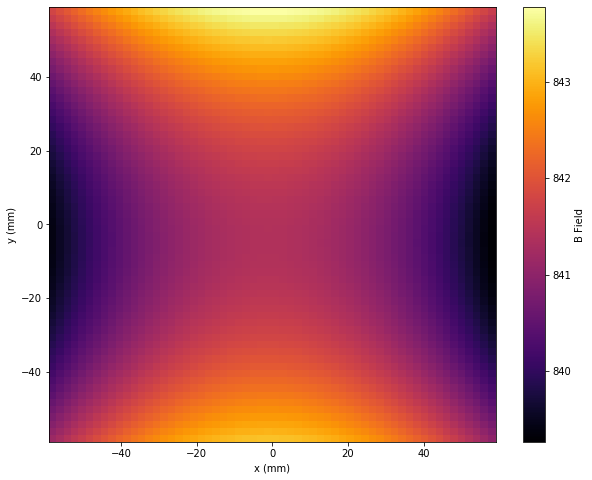

In [127]:
df_field_grid = get_field_grid(b)
fig = plot_field(df_field_grid)
fig

# Get the tracker info

In [128]:
import sys
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/tracker_info'
sys.path.append(path)
from beam_moments import *
from transform_beam import *

__Plot the beam readout from two different tracker locations as well as the difference__

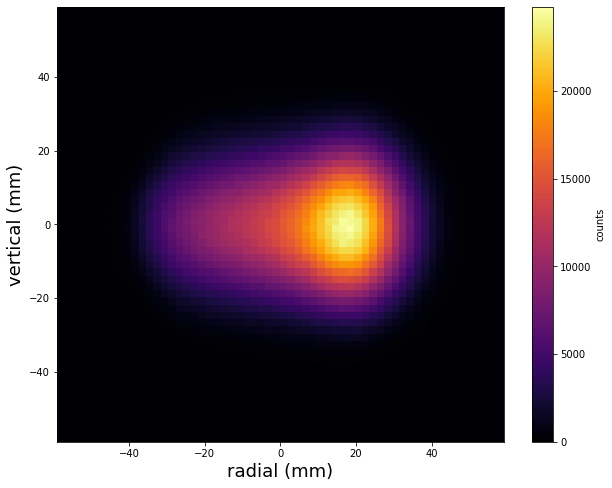

In [256]:
df_tracker = get_df_tracker()
#only look at station 12 or 18
mask12 = (df_tracker["Station"] == 'station12')
mask18 = (df_tracker["Station"] == 'station18')

df_12 = df_tracker[mask12].copy()
df_12['counts_norm'] = df_12['counts']/df_12['counts'].sum()
fig = plot_beam(df_12,bins=60)
fig
# df_12.head(6)

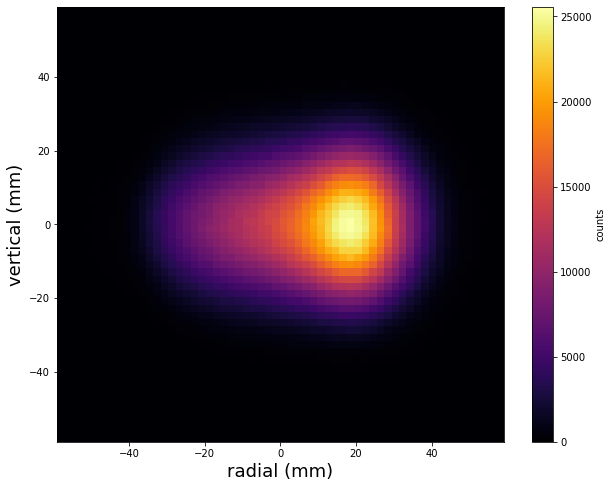

In [257]:
df_18 = df_tracker[mask18].copy()
df_18.reset_index(inplace=True)
df_18 = df_18.drop(columns=['level_0'])
df_18['counts_norm'] = df_18['counts']/df_18['counts'].sum()
fig = plot_beam(df_18,bins=60)
fig
# df_18.head(6)

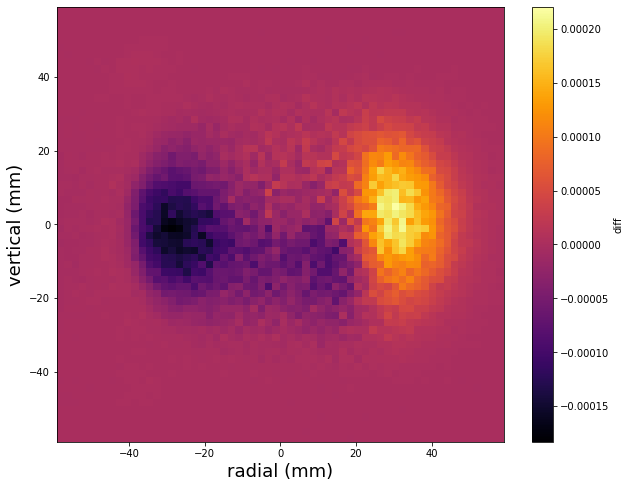

In [258]:
df_diff = pd.DataFrame()
df_diff['radial'] = df_12['radial']
df_diff['vertical'] = df_12['vertical']
df_diff['diff'] = (df_18['counts_norm'] -  df_12['counts_norm'])

fig = plot_beam(df_diff,bins=60,var='diff')
fig
# df_diff.head(6)

# Now get the difference-weighted B field  to see the size of the effect

In [259]:
#calculate the dipole
dipole = b[0]
#calculate the total field for the difference distribution
diff_field = (df_diff['diff']*df_field_grid['B']).sum()
diff_field

-0.012285498363805658

__so we see that the two stations produce a 12 ppb difference muon averaged B-field__

In a similar way, take the difference between the field as seen in the two stations.


also note that the muon averaged b field is invarient to the scale of the ctags:

In [269]:
field_12 = (df_12['counts']*df_field_grid['B']).sum()/(df_12['counts'].sum())
field_12

841.2667976859057

In [270]:
field_12 = (df_12['counts_norm']*df_field_grid['B']).sum()
field_12

841.2667976859057

In [275]:
field_18 = (df_18['counts_norm']*df_field_grid['B']).sum()
field_12
diff_field2 = field_18 - field_12
diff_field2

-0.012285498363780789

which is just about the same value as found in the alternate method:

In [276]:
diff_field - diff_field2

-2.4868995751603507e-14

# Now we can use an emulation to move the beam around to see the effect on the final muon-weighted average

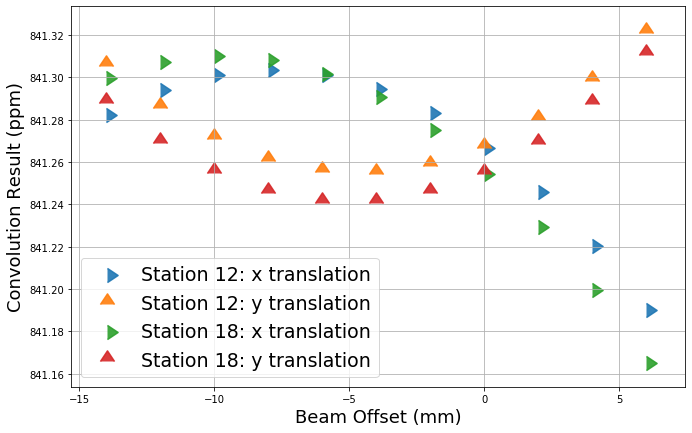

In [286]:
spacing = 2.001
low = -14
high=7
fig = plt.figure(figsize=(11,7))


#####Station 12########
B_arr = np.empty(0)
x_range = np.arange(low,high,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_12,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=9,
            label="Station 12: x translation",s=200)

B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_12,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker=10,
            label="Station 12: y translation",s=200)

#####Station 18########
B_arr = np.empty(0)
x_range = np.arange(low,high,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_18,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=9,
            label="Station 18: x translation",s=200)

B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_18,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker=10,
            label="Station 18: y translation",s=200)



plt.xlabel("Beam Offset (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.legend(prop={'size': 19})
plt.grid()
plt.show()

__So we see that vertical offsets about zero produces a $\pm$10 ppb effect for $\pm$ 2 mm of motion__


__And radial offsets about zero produces a $\pm$18 ppb effect for $\pm$ 2 mm of motion__

__This means that, if the uncertainty in the beam is 0.5 mm in both directions, then the very worst we can do is $\sqrt((18/4)^2 + (10/4)^2)$ = 5.1 ppb

# Now we want to produce the same plot, but using a narrower/wider beam

Specifically, we want to subract the effect of detection off the beam. It has been shown in https://gm2-docdb.fnal.gov/cgi-bin/private/RetrieveFile?docid=18094&filename=2019_05_30_Tracker_Pitch.pdf&version=2
that the vertical and hoizantal resolution of the tracker is 3 mm, so this is what we want to subract.

In [16]:
df_narrow = df_tracker.copy()



df_narrow['counts']
w = df_narrow['counts']
v = df_narrow['vertical']
r = df_narrow['radial']
m_r = get_mean(r,w) #the radial mean
m_v = get_mean(v,w) #the vertical mean
rms_r = get_rms(r,m_r,w) #the radial rms
rms_v = get_rms(v,m_v,w) #the vertical rms


#first shift the beam
# df_narrow = shift_beam(df_narrow,-2.64,0)
#now narrow the beam
df_narrow = narrow(df_narrow,1.7,'counts','narrow')

w = df_narrow['narrow']
v = df_narrow['vertical']
r = df_narrow['radial']
m_r_new = get_mean(r,w) #the radial mean
m_v_new = get_mean(v,w) #the vertical mean
rms_r_new = get_rms(r,m_r_new,w) #the radial rms
rms_v_new = get_rms(v,m_v_new,w) #the vertical rms

print("original radial mean and rms:",m_r,rms_r)
print("original vertical mean and rms:",m_v,rms_v,'\n')

print("new radial mean and rms:",m_r_new,rms_r_new)
print("new vertical mean and rms:",m_v_new,rms_v_new,'\n')

print("radial change in mean and rms:",m_r_new - m_r,rms_r_new - rms_r)
print("vertical change in mean and rms:",m_v_new - m_v,rms_v_new - rms_v)


original radial mean and rms: 6.7936760480339125 18.256241636284077
original vertical mean and rms: -0.005800812143173988 12.805590974050983 

new radial mean and rms: 9.439720734489155 15.286170257105889
new vertical mean and rms: -0.14103951348483268 10.298741000142906 

radial change in mean and rms: 2.6460446864552427 -2.9700713791781883
vertical change in mean and rms: -0.1352387013416587 -2.5068499739080767


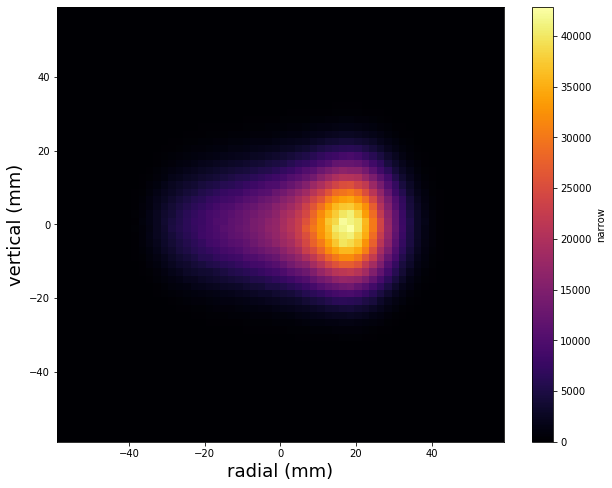

In [17]:
plot_beam(df_narrow,var='narrow')

In [98]:
mask = df_tracker['Station'] == 'station12'
df_conv = df_tracker[mask].copy()

c = convolve_df(df_conv,60,3)
df_conv['conv'] = c

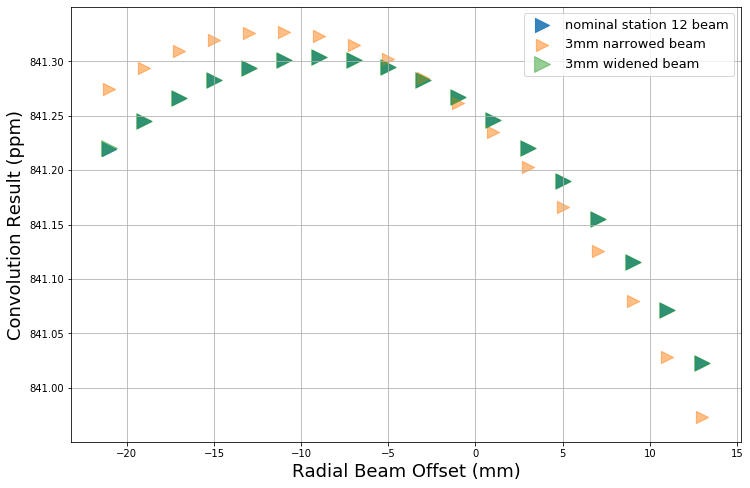

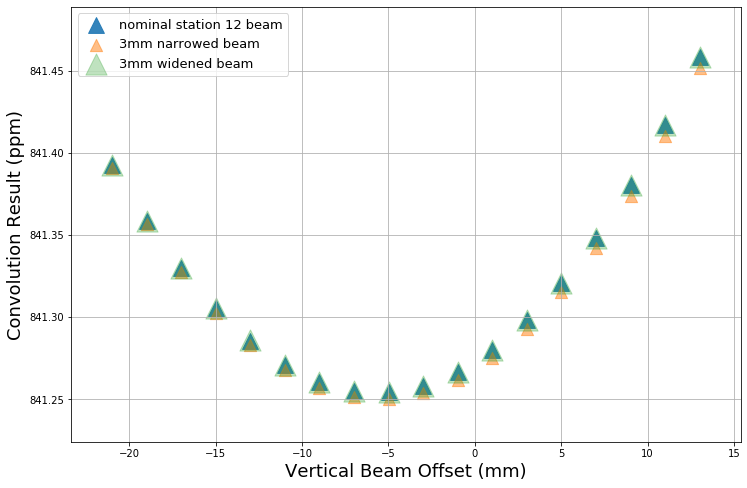

In [103]:
spacing = 2.001

fig = plt.figure(figsize=(12,8))
B_arr = np.empty(0)
x_range = np.arange(-21,14,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_tracker,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=">",s=200,
            label="nominal station 12 beam")






##narrowed beam


df_narrow['counts'] = df_narrow['narrow']
yshift = 0
x_range = np.arange(-21,14,spacing)
B_arr = np.empty(0)
for xshift in x_range:
    df = shift_beam(df_narrow,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.5, marker=">",s=150,
            label="3mm narrowed beam")



#widened beam
df_conv['counts'] = df_conv['conv']
yshift = 0
x_range = np.arange(-21,14,spacing)
B_arr = np.empty(0)
for xshift in x_range:
    df = shift_beam(df_conv,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.5, marker=">",s=250,
            label="3mm widened beam")


plt.xlabel("Radial Beam Offset (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.legend(prop={'size': 13})
plt.grid()
plt.show()









B_arr = np.empty(0)
y_range = np.arange(-21,14,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_tracker,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker="^",s=250,
            label="nominal station 12 beam")



B_arr = np.empty(0)
y_range = np.arange(-21,14,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_narrow,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.5,marker="^",s=150,
            label="3mm narrowed beam")





B_arr = np.empty(0)
y_range = np.arange(-21,14,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_conv,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.3,marker="^",s=450,
            label="3mm widened beam")




plt.xlabel("Vertical Beam Offset (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.legend(prop={'size': 13})
plt.grid()
plt.show()





# Now look at a plot of convolution result vs broadening 

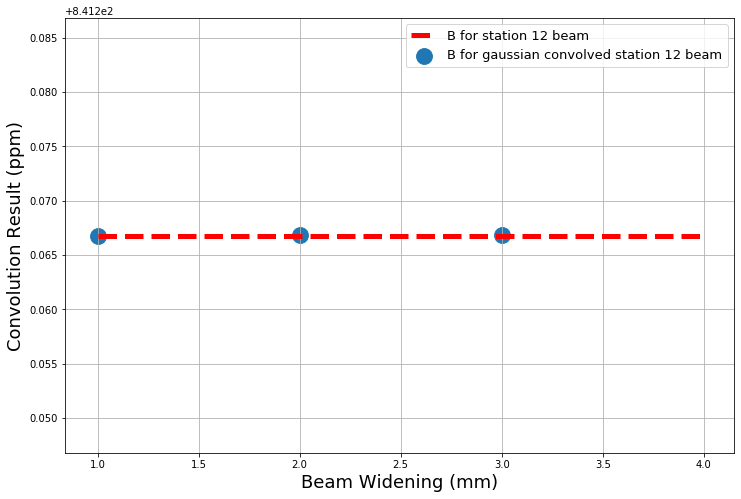

In [120]:
fig = plt.figure(figsize=(12,8))
mask = df_tracker['Station'] == 'station12'
df_conv = df_tracker[mask].copy()

spacing = 1
high = 4

B_arr = np.empty(0)
sigmas = np.arange(spacing,high,spacing)
for sigma in sigmas:
    c = convolve_df(df_conv,60,sigma)
    df_conv['conv'] = c
    df_conv['conv'] = df_conv['conv']
    B = (df_conv['conv']*df_field_grid['B']).sum()/(df_conv['conv'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(sigmas, B_arr,marker="o",
            s=250,label='B for gaussian convolved station 12 beam')


#B for the regular beam
B = (df_conv['counts']*df_field_grid['B']).sum()/(df_conv['counts'].sum())
plt.plot([spacing, high], [B, B], 
         linestyle='--', linewidth=5, color='red',label='B for station 12 beam')


'''



#do the same with a centered gaussian beam
B_arr = np.empty(0)
sigmas = np.arange(spacing,high,spacing)
for sigma in sigmas:
    g = gaussian_kernel(59,sigma)
    g = np.reshape(g, (60*60),-1)
    df_conv['gaus'] = g
    B = (df_conv['gaus']*df_field_grid['B']).sum()/(df_conv['gaus'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(sigmas, B_arr,marker="o",
            s=250, label='B for centered gaussian')




#Just the ctag weighted dipole
D = (df_total["D"]*df_total["ctags_per_second"]).sum()/df_total["ctags_per_second"].sum()
plt.plot([spacing, high], [D, D], 
         linestyle='--', linewidth=5, color='green',label='ctag-avg dipole')
'''

#Just the time-weighted dipole
# D = df_total["D"].mean()
# plt.plot([spacing, high], [D, D], 
#          linestyle='-', linewidth=2,label='time-avg dipole')


plt.xlabel("Beam Widening (mm)",fontsize=18)
plt.ylabel("Convolution Result (ppm)",fontsize=18)
plt.grid()
plt.legend(prop={'size': 13})
plt.show()
    

In [121]:
(df_conv['conv']*df_field_grid['B']).sum()/df_conv['conv'].sum()

841.2668314979117

In [122]:
(df_conv['counts']*df_field_grid['B']).sum()/df_conv['counts'].sum()

841.2667976859057

In [119]:
df_conv['counts'].var()

23311491.869963802

In [46]:
df_conv['counts']*df_field_grid['B']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3595    0.0
3596    0.0
3597    0.0
3598    0.0
3599    0.0
Length: 3600, dtype: float64

# The B field is the same everywhere, so the weighting should not matter

In [47]:
mask = (df_conv['conv'] < 0.1 )
# mask = ~mask
df_conv[mask]
df_conv

,index,radial,vertical,counts,Station,conv,gaus
0,2,-59.0,-59.0,0.0,station12,0.818908,2.223240e-52
1,3,-59.0,-57.0,0.0,station12,1.290517,1.028917e-50
2,4,-59.0,-55.0,0.0,station12,2.026184,4.172021e-49
3,5,-59.0,-53.0,0.0,station12,2.916746,1.482127e-47
4,6,-59.0,-51.0,0.0,station12,3.791581,4.613145e-46
5,7,-59.0,-49.0,16.0,station12,4.468454,1.258002e-44
6,8,-59.0,-47.0,10.0,station12,4.832627,3.005648e-43
7,9,-59.0,-45.0,2.0,station12,4.896724,6.291695e-42
8,10,-59.0,-43.0,6.0,station12,4.804796,1.153904e-40
9,11,-59.0,-41.0,3.0,station12,4.784863,1.854149e-39


In [48]:
df_field_grid.head()

,x,y,B
0,-59.0,-59.0,841.153815
1,-59.0,-57.0,841.028336
2,-59.0,-55.0,840.907562
3,-59.0,-53.0,840.791493
4,-59.0,-51.0,840.680130


In [49]:
df_conv['gaus'].var()

2.846586020506274e-06

In [50]:
df_field_grid.iloc[0,2]

841.1538147333189

In [51]:
df_field_grid['B'].mean()

841.4022102960945

In [52]:
mask = (df_field_grid["B"] != df_field_grid.iloc[0,2])
df_field_grid[mask].head()

,x,y,B
1,-59.0,-57.0,841.028336
2,-59.0,-55.0,840.907562
3,-59.0,-53.0,840.791493
4,-59.0,-51.0,840.680130
5,-59.0,-49.0,840.573471


In [53]:
a = (df_field_grid["B"]*df_conv["counts"]).sum()/df_conv["counts"].sum()
a
# df_conv["counts"].sum()

841.2667976859057

In [54]:
a = (df_field_grid["B"]*df_conv["conv"]).sum()/df_conv["conv"].sum()
a
# df_conv["conv"].sum()

841.2708282655942

In [55]:
# a = (df_field_grid["B"]*df_conv["gaus"])
# a = df_conv['gaus']
# a = df_field_grid['B']
# a

In [56]:
df_field_grid['B'].mean()

841.4022102960945

In [57]:
(df_total["D"]*df_total["ctags_per_second"]).sum()/total_ctags

841.4022102960945

In [58]:
df_total["D"].mean()

841.3653730688554

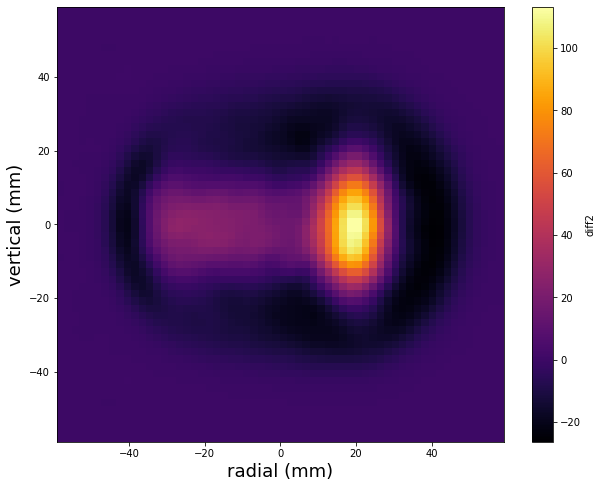

In [114]:
c = convolve_df(df_conv,60,0.3)
df_conv['conv'] = c
df_conv['diff'] = df_conv['conv'] - df_conv['counts']
c = convolve_df(df_conv,60,1)
df_conv['conv2'] = c
df_conv['diff2'] = df_conv['conv'] - df_conv['conv2']
plot_beam(df_conv,var='diff2')

In [60]:
mask = df_tracker['Station'] == 'station12'
df_test = df_tracker[mask].copy()
df_test.head()

,index,radial,vertical,counts,Station
0,2,-59.0,-59.0,0.0,station12
1,3,-59.0,-57.0,0.0,station12
2,4,-59.0,-55.0,0.0,station12
3,5,-59.0,-53.0,0.0,station12
4,6,-59.0,-51.0,0.0,station12


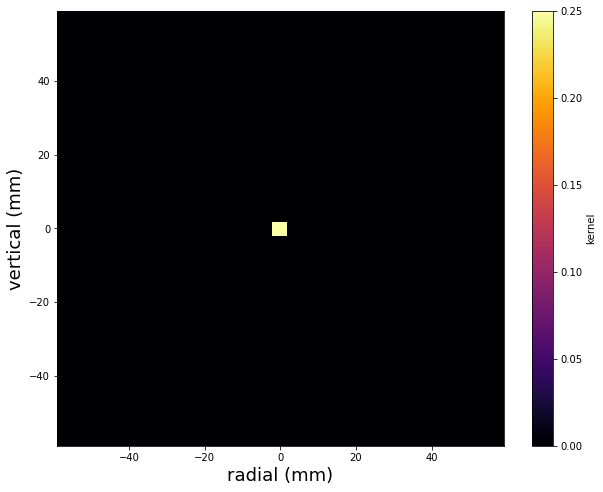

In [72]:
g = gaussian_kernel(59,0.1)
g = np.reshape(g, (60*60),-1)
# g
df_test['kernel'] = g
plot_beam(df_test,var='kernel')

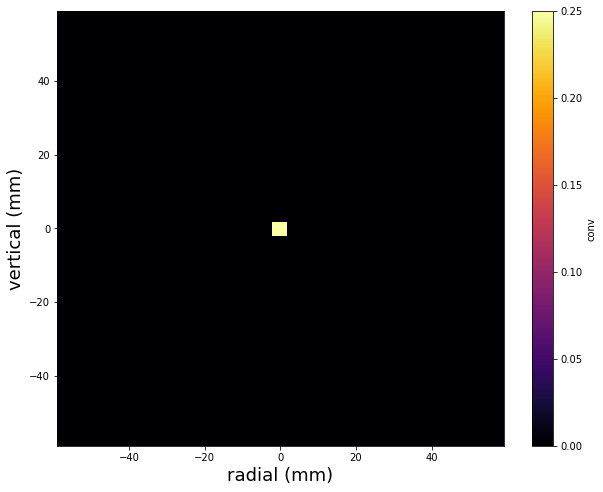

In [80]:
c = convolve_df(df_test,60,0.001,var='kernel')
df_test['conv'] = c
plot_beam(df_test,var='conv')
# df_test

In [63]:
size = 15
g = gaussian_kernel(size,0.03)
g = np.reshape(g, ((size+1)**2),-1)
sum(g)
type(g[0])

numpy.float64